In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [27]:
############Step1###############
# ---- 1.1 Load raw data ----
import pandas as pd
import os

# Path and file choice
data_dir = "/content/drive/MyDrive/Project Dataset/MTP Dataset"
fd = "FD001"   # change if you want FD002, FD003, etc.

# Define column names
col_names = ['unit_id', 'cycle',
             'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
            [f'sensor_{i}' for i in range(1, 22)]

# Load datasets (handling multiple spaces with sep="\s+")
train_df = pd.read_csv(os.path.join(data_dir, f"train_{fd}.txt"),
                       sep=r"\s+", header=None, names=col_names)
test_df  = pd.read_csv(os.path.join(data_dir, f"test_{fd}.txt"),
                       sep=r"\s+", header=None, names=col_names)
rul_df   = pd.read_csv(os.path.join(data_dir, f"RUL_{fd}.txt"),
                       sep=r"\s+", header=None).values.squeeze()

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
print("RUL shape  :", rul_df.shape)
print(train_df)

Train shape: (20631, 26)
Test shape : (13096, 26)
RUL shape  : (100,)
       unit_id  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0            1      1       -0.0007       -0.0004         100.0    518.67   
1            1      2        0.0019       -0.0003         100.0    518.67   
2            1      3       -0.0043        0.0003         100.0    518.67   
3            1      4        0.0007        0.0000         100.0    518.67   
4            1      5       -0.0019       -0.0002         100.0    518.67   
...        ...    ...           ...           ...           ...       ...   
20626      100    196       -0.0004       -0.0003         100.0    518.67   
20627      100    197       -0.0016       -0.0005         100.0    518.67   
20628      100    198        0.0004        0.0000         100.0    518.67   
20629      100    199       -0.0011        0.0003         100.0    518.67   
20630      100    200       -0.0032       -0.0005         100.0    518.67   

     

In [28]:
# ---- 1.2Add RUL column to training data ----
rul_train = train_df.groupby('unit_id')['cycle'].max().reset_index()
rul_train.columns = ['unit_id', 'max_cycle']

train_df = train_df.merge(rul_train, on='unit_id', how='left')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop('max_cycle', axis=1, inplace=True)

# Cap RUL at 125 cycles (NASA standard)
train_df['RUL'] = train_df['RUL'].clip(upper=125)


In [29]:
import numpy as np
import pandas as pd

# ---- 1.3PSGS Metric Functions ----

def monotonicity(series):
    """Measures fraction of time derivative signs that are consistent."""
    diffs = np.diff(series)
    pos = np.sum(diffs > 0)
    neg = np.sum(diffs < 0)
    return abs(pos - neg) / len(diffs) if len(diffs) > 0 else 0

def trendability(sensor_df, rul_col="RUL"):
    """Correlation of sensor with RUL across all engines."""
    return abs(sensor_df.corr()[rul_col].drop(rul_col)).values

def prognosability(df, sensor_col, rul_col="RUL"):
    """Variance of sensor value at failure across engines."""
    last_vals = df.groupby("unit_id")[sensor_col].last()
    return 1 / (1 + np.var(last_vals))  # smaller variance → better

def correlation_with_rul(df, sensor_col, rul_col="RUL"):
    """Absolute Pearson correlation with RUL."""
    return abs(df[sensor_col].corr(df[rul_col]))

# ----1.4 PSGS Selection ----
def psgs_sensor_selection(train_df, sensor_cols, top_k=10):
    scores = {}
    for sensor in sensor_cols:
        # Metrics
        mono = train_df.groupby("unit_id")[sensor].apply(monotonicity).mean()
        corr = correlation_with_rul(train_df, sensor)
        prog = prognosability(train_df, sensor)

        # Weighted PSGS score (tune weights as needed)
        score = 0.4 * corr + 0.3 * mono + 0.3 * prog
        scores[sensor] = score

    # Sort sensors by score
    sorted_sensors = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    selected = [s[0] for s in sorted_sensors[:top_k]]

    return selected, scores

sensor_cols = [f"sensor_{i}" for i in range(1, 22)]
selected_sensors, all_scores = psgs_sensor_selection(train_df, sensor_cols, top_k=12)

print("✅ Selected Sensors:", selected_sensors)
print("\n📊 PSGS Scores per Sensor:")
for s, score in all_scores.items():
    print(f"{s}: {score:.4f}")


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


✅ Selected Sensors: ['sensor_1', 'sensor_10', 'sensor_11', 'sensor_15', 'sensor_12', 'sensor_2', 'sensor_8', 'sensor_13', 'sensor_7', 'sensor_17', 'sensor_6', 'sensor_4']

📊 PSGS Scores per Sensor:
sensor_1: nan
sensor_2: 0.5596
sensor_3: 0.2871
sensor_4: 0.3319
sensor_5: 0.3000
sensor_6: 0.3434
sensor_7: 0.5536
sensor_8: 0.5582
sensor_9: 0.1985
sensor_10: nan
sensor_11: 0.6173
sensor_12: 0.5746
sensor_13: 0.5565
sensor_14: 0.1637
sensor_15: 0.5997
sensor_16: 0.3000
sensor_17: 0.4233
sensor_18: nan
sensor_19: nan
sensor_20: 0.5892
sensor_21: 0.5925


In [30]:
# ---- 1.5 Keep only selected sensors ----
train_df = train_df[['unit_id', 'cycle'] + selected_sensors + ['RUL']]
test_df  = test_df[['unit_id', 'cycle'] + selected_sensors]

# ---- 1.6 Normalize ----
scaler = StandardScaler()
scaler.fit(train_df[selected_sensors])

train_df[selected_sensors] = scaler.transform(train_df[selected_sensors])
test_df[selected_sensors]  = scaler.transform(test_df[selected_sensors])
print(train_df.shape)
print(test_df.shape)

(20631, 15)
(13096, 14)


In [31]:
# ---- 7. Label RUL for test set ----
rul_test_df = pd.DataFrame(rul_df, columns=['RUL'])
rul_test_df['unit_id'] = test_df['unit_id'].unique()

rul_test_cycles = test_df.groupby('unit_id')['cycle'].max().reset_index()
rul_test_cycles.columns = ['unit_id', 'last_cycle']

rul_test_df = rul_test_df.merge(rul_test_cycles, on='unit_id', how='left')

test_df = test_df.merge(rul_test_df[['unit_id', 'RUL', 'last_cycle']], on='unit_id', how='left')
test_df['RUL'] = test_df['RUL'] + (test_df['last_cycle'] - test_df['cycle'])
test_df['RUL'] = test_df['RUL'].clip(upper=125)
test_df.drop('last_cycle', axis=1, inplace=True)

# ---- Final check ----
print("\nProcessed training data:")
print(train_df.head())
print(train_df.shape)
print(test_df.shape)


Processed training data:
   unit_id  cycle  sensor_1  sensor_10  sensor_11  sensor_15  sensor_12  \
0        1      1       0.0        0.0  -0.266467  -0.603816   0.334262   
1        1      2       0.0        0.0  -0.191583  -0.275852   1.174899   
2        1      3       0.0        0.0  -1.015303  -0.649144   1.364721   
3        1      4       0.0        0.0  -1.539489  -1.971665   1.961302   
4        1      5       0.0        0.0  -0.977861  -0.339845   1.052871   

   sensor_2  sensor_8  sensor_13  sensor_7  sensor_17  sensor_6  sensor_4  RUL  
0 -1.721725 -0.516338  -1.058890  1.121141  -0.781710  0.141683 -0.925936  125  
1 -1.061780 -0.798093  -0.363646  0.431930  -0.781710  0.141683 -0.643726  125  
2 -0.661813 -0.234584  -0.919841  1.008155  -2.073094  0.141683 -0.525953  125  
3 -0.661813  0.188048  -0.224597  1.222827  -0.781710  0.141683 -0.784831  125  
4 -0.621816 -0.516338  -0.780793  0.714393  -0.136018  0.141683 -0.301518  125  
(20631, 15)
(13096, 15)


In [32]:

# -----------------------------
# STEP 2: WINDOWING SEQUENCES (with padding)
# -----------------------------

# ---- Parameters ----
seq_len = 50   # longer history window
stride   = 1   # sliding step (can increase to reduce dataset size)

def make_sequences(df, seq_len, selected_sensors, rul_col='RUL'):
    """
    Convert FD data into overlapping sequences of length `seq_len`
    Each sequence = [unit_id, seq_len steps, sensors]
    Target = RUL at last timestep
    """
    X, y = [], []
    for unit_id in df['unit_id'].unique():
        unit_df = df[df['unit_id']==unit_id]
        unit_data = unit_df[selected_sensors].values
        unit_rul  = unit_df[rul_col].values

        # Slide window with stride
        for i in range(0, len(unit_data) - seq_len + 1, stride):
            X.append(unit_data[i:i+seq_len])
            y.append(unit_rul[i+seq_len-1])  # RUL at last step
    return np.array(X), np.array(y)

# ---- Apply sequence generation ----
X_train, y_train = make_sequences(train_df, seq_len, selected_sensors)
X_test,  y_test  = make_sequences(test_df,  seq_len, selected_sensors)

print("Train X shape:", X_train.shape)
print("Train y shape:", y_train.shape)
print("Test X shape :", X_test.shape)
print("Test y shape :", y_test.shape)


Train X shape: (15731, 50, 12)
Train y shape: (15731,)
Test X shape : (8255, 50, 12)
Test y shape : (8255,)


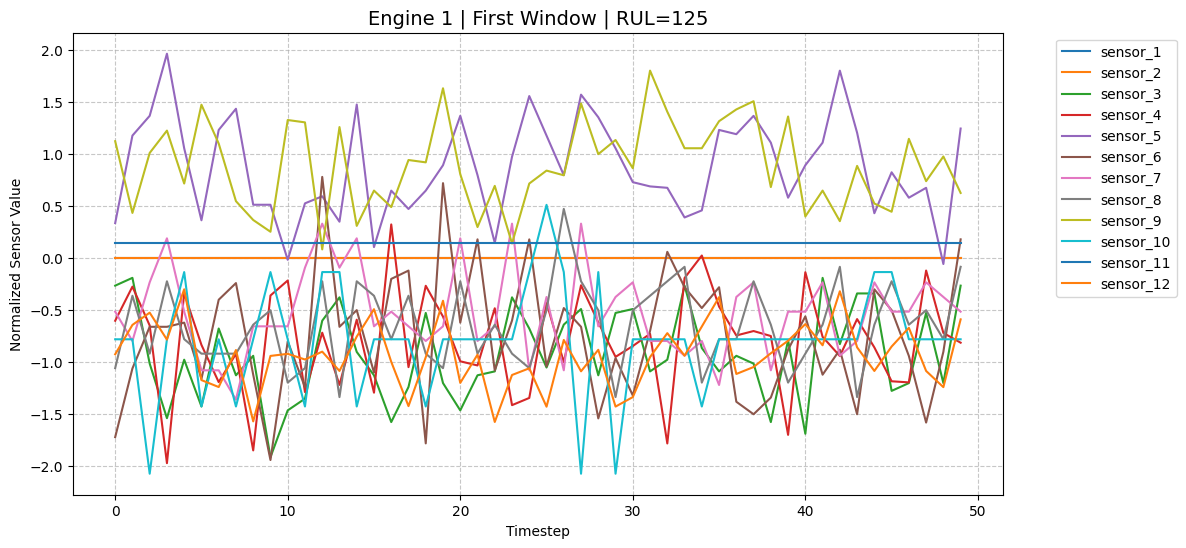

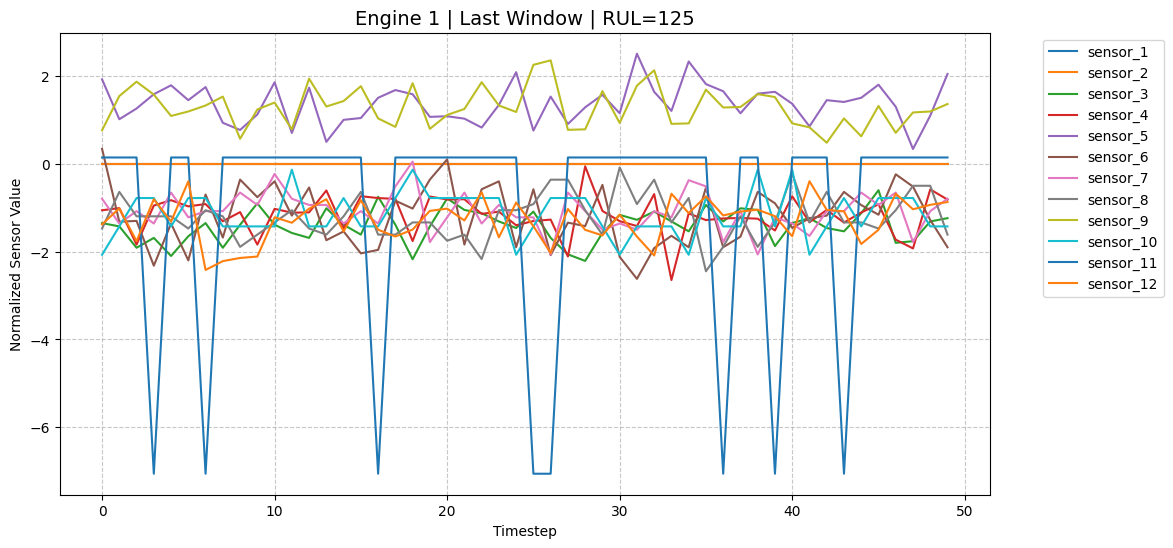

In [34]:
import matplotlib.pyplot as plt


def plot_engine_sequences(X, y, df, engine_id, sensor_names=None):
    """
    Plot first and last window for a given engine.
    """
    # Get all row indices for this engine
    idxs = df[df['unit_id'] == engine_id].index.tolist()

    if not idxs:
        print(f"Engine {engine_id} not found in dataset.")
        return

    # First and last windows in X (aligned with df order)
    first_idx = idxs[0]
    last_idx  = idxs[-1]

    for i, seq_idx in enumerate([first_idx, last_idx]):
        seq = X[seq_idx]
        rul_value = y[seq_idx]

        plt.figure(figsize=(12,6))
        for j in range(seq.shape[1]):
            label = sensor_names[j] if sensor_names else f'Sensor {j+1}'
            plt.plot(seq[:, j], label=label)

        title = "First Window" if i == 0 else "Last Window"
        plt.title(f"Engine {engine_id} | {title} | RUL={rul_value}", fontsize=14)
        plt.xlabel("Timestep")
        plt.ylabel("Normalized Sensor Value")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

# ---- Example: Check Engine 1 ----
plot_engine_sequences(X_train, y_train, train_df, engine_id=1, sensor_names=sensor_cols)


Showing engine 67


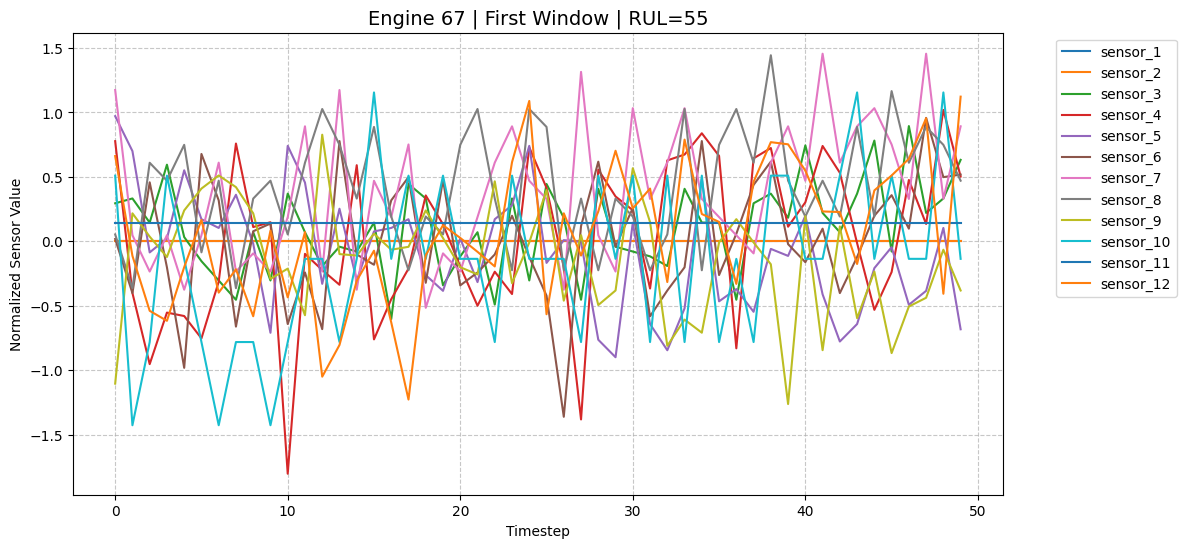

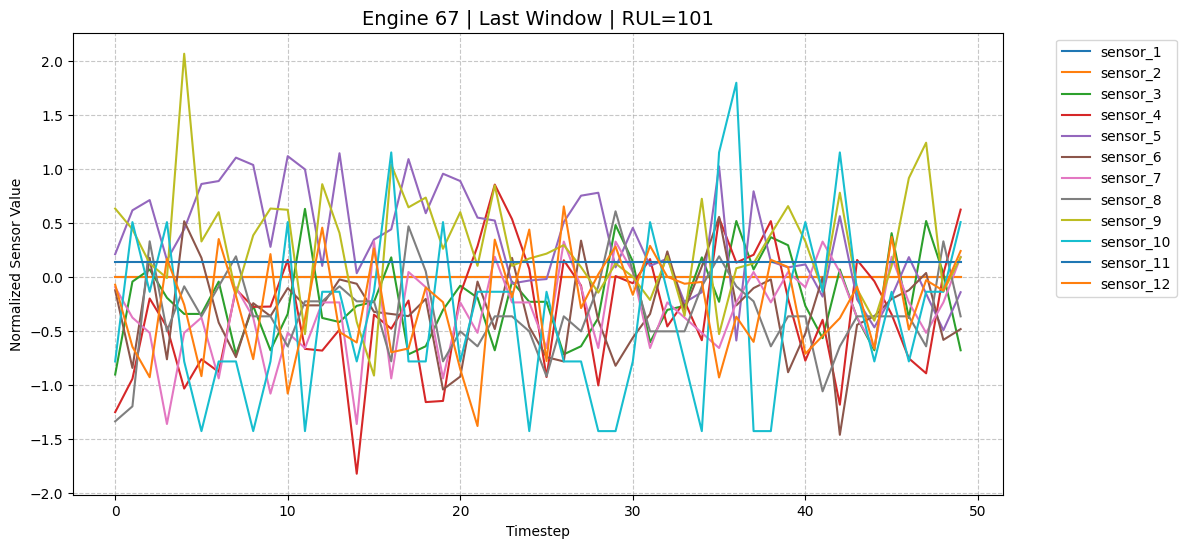

In [35]:
import random

def plot_random_engine(X, y, df, sensor_names=None):
    """
    Pick a random engine and plot its first and last windows.
    """
    engine_id = random.choice(df['unit_id'].unique())
    print(f"Showing engine {engine_id}")
    plot_engine_sequences(X, y, df, engine_id, sensor_names)

# ---- Example usage ----
plot_random_engine(X_train, y_train, train_df, sensor_names=sensor_cols)


In [36]:
##########Step 3###############
#3.1
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout

def build_cnn_bilstm(seq_len, n_features):
    model = Sequential([
        # --- 1D CNN Block (2 layers) ---
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_len, n_features)),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        # --- Bidirectional LSTM ---
        Bidirectional(LSTM(100, return_sequences=False)),
        Dropout(0.2),

        # --- Dense Layers ---
        Dense(100, activation='relu'),
        Dense(50, activation='relu'),
        Dense(1)   # output: RUL prediction
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
        loss='mse',
        metrics=['mae']
    )
    return model

# ---- Build improved model ----
seq_len = 50   # longer history window
n_features = X_train.shape[2] # keep same sensor count
model = build_cnn_bilstm(seq_len, n_features)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 48, 64)         │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 46, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200)            │       132,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,921 (671.57 KB)

 Trainable params: 171,921 (671.57 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
#3.2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,             # allow more patience (was 10)
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_cnn_bilstm.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,             # reduce LR by half
    patience=5,             # if no improvement for 5 epochs
    min_lr=1e-6,
    verbose=1
)

# -----------------------------
# Train model
# -----------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.2,   # keep test set untouched
    epochs=100,             # allow longer training
    batch_size=64,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)


Epoch 1/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 3853.5425 - mae: 50.5827
Epoch 1: val_loss improved from inf to 515.10785, saving model to best_cnn_bilstm.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 25s 105ms/step - loss: 3844.4138 - mae: 50.5066 - val_loss: 515.1078 - val_mae: 19.2598 - learning_rate: 5.0000e-04
Epoch 2/100
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 419.6616 - mae: 16.2675
Epoch 2: val_loss improved from 515.10785 to 261.14600, saving model to best_cnn_bilstm.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - loss: 419.0443 - mae: 16.2530 - val_loss: 261.1460 - val_mae: 12.3545 - learning_rate: 5.0000e-04
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 252.9241 - mae: 12.3393
Epoch 3: val_loss improved from 261.14600 to 194.84056, saving model to best_cnn_bilstm.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - loss: 252.8505 - mae: 12.3372 - val_loss: 194.8406 - val_mae: 10.7042 - learning_rate: 5.0000e-04
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 198.8061 - mae: 10.7995
Epoch 4: val_loss improved from 194.84056 to 192.73714, saving model to best_cnn_bilstm.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - loss: 198.7877 - mae: 10.7990 - val_loss: 192.7371 - val_mae: 10.4729 - learning_rate: 5.0000e-04
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 177.0234 - mae: 10.0664
Epoch 5: val_loss did not improve from 192.73714
197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - loss: 177.0088 - mae: 10.0660 - val_loss: 200.2197 - val_mae: 11.5639 - learning_rate: 5.0000e-04
Epoch 6/100
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 152.6629 - mae: 9.3371
Epoch 6: val_loss improved from 192.73714 to 183.70496, saving model to best_cnn_bilstm.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - loss: 152.6677 - mae: 9.3368 - val_loss: 183.7050 - val_mae: 10.3136 - learning_rate: 5.0000e-04
Epoch 7/100
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 143.0822 - mae: 8.8788
Epoch 7: val_loss did not improve from 183.70496
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - loss: 143.0522 - mae: 8.8781 - val_loss: 216.2592 - val_mae: 11.2228 - learning_rate: 5.0000e-04
Epoch 8/100
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 129.5931 - mae: 8.5497
Epoch 8: val_loss did not improve from 183.70496
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - loss: 129.5763 - mae: 8.5488 - val_loss: 231.9697 - val_mae: 11.4762 - learning_rate: 5.0000e-04
Epoch 9/100
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 121.0391 - mae: 8.1661
Epoch 9: val_loss did not improve from 183.70496
197/197 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - loss: 120.9961 - mae: 8.1651 - val_loss: 220.9868 - val_mae: 11.1566 - learning_rate: 5.0000e-04
Epoch 10/100
196/197 ━━━━━━━━━

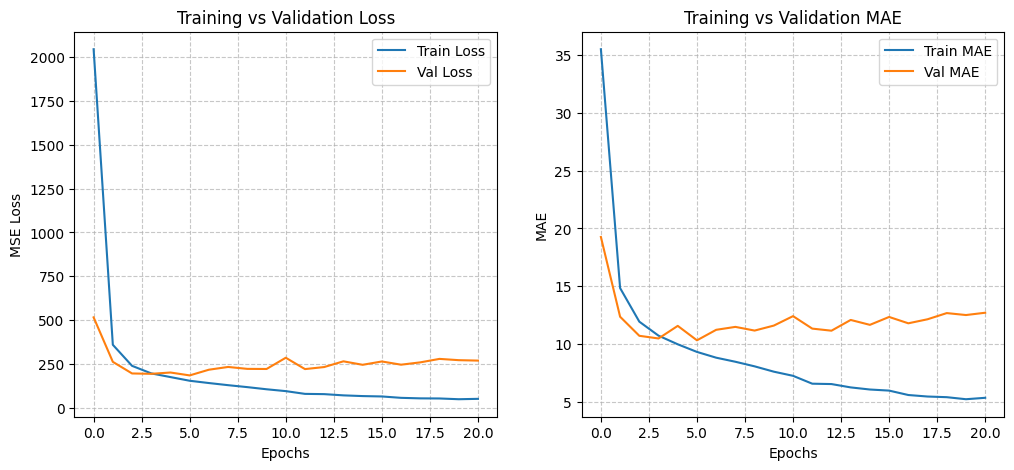

In [38]:
# =====================================================
# Step 4A. Training History Plots
# =====================================================
def plot_training_history(history):
    plt.figure(figsize=(12,5))

    # --- Loss plot ---
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # --- MAE plot ---
    plt.subplot(1,2,2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.title("Training vs Validation MAE")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.show()

# ---- Call after training ----
plot_training_history(history)



In [40]:
# =====================================================
# Step 4B. Test Evaluation
# =====================================================
# Load best saved weights
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.load_weights('best_cnn_bilstm.h5')

# Predict on test set
y_pred = model.predict(X_test).flatten()

# Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print("✅ Test Results")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
✅ Test Results
MSE : 196.4901
MAE : 10.6570
R²  : 0.8000


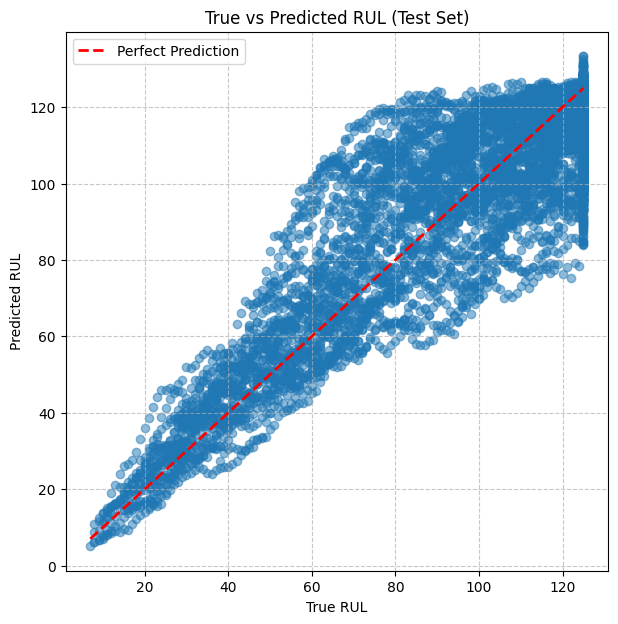

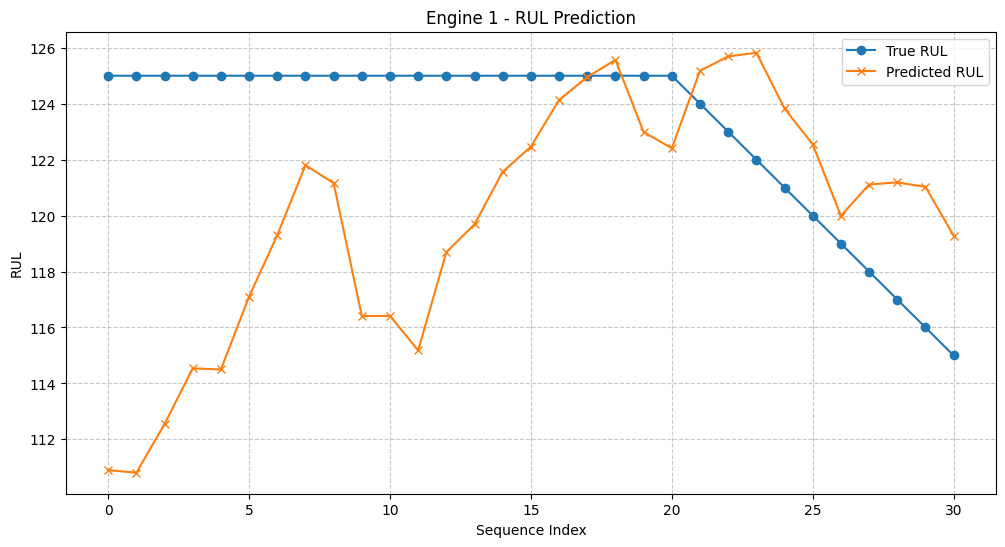

In [41]:
# =====================================================
# Step 4C. Visualization of Predictions
# =====================================================
# --- Scatter Plot (True vs Predicted) ---
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2, label="Perfect Prediction")
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("True vs Predicted RUL (Test Set)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --- Line Plot (Sample Engines) ---
def plot_engine_predictions(unit_id, df, X, y_true, y_pred, seq_len=30):
    idxs = df[df['unit_id']==unit_id].index.tolist()
    if not idxs:
        print(f"Engine {unit_id} not found in test set")
        return

    plt.figure(figsize=(12,6))
    plt.plot(idxs, y_true[idxs], label="True RUL", marker='o')
    plt.plot(idxs, y_pred[idxs], label="Predicted RUL", marker='x')
    plt.title(f"Engine {unit_id} - RUL Prediction")
    plt.xlabel("Sequence Index")
    plt.ylabel("RUL")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Example: visualize Engine 1 predictions
plot_engine_predictions(1, test_df, X_test, y_test, y_pred)


In [ ]:
# =====================================================
# Step 4D. PHM Score
# =====================================================
def phm_score(y_true, y_pred):
    score = 0.0
    for t, p in zip(y_true, y_pred):
        d = p - t
        if d < 0:
            score += np.exp(-d/13) - 1
        else:
            score += np.exp(d/10) - 1
    return score

phm = phm_score(y_test, y_pred)
print(f"PHM Score : {phm:.4f}")